In [1]:
!pip install --upgrade tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPool2D,MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [4]:
print(tf.__version__)

2.11.0


In [18]:
IMG_WIDTH = 255
IMG_HEIGHT = 255
BATCH_SIZE = 32

In [19]:
train_dataset_path = '/content/drive/MyDrive/FakevsReal/FakevsReal/train'
validation_dataset_path = '/content/drive/MyDrive/FakevsReal/FakevsReal/Validation'

In [20]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 2634 images belonging to 2 classes.


In [21]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(validation_dataset_path,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 1116 images belonging to 2 classes.


In [22]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : fake
1 : real


In [23]:
base_model = tf.keras.applications.ConvNeXtTiny(
                     include_top=False,
                     weights='imagenet',
                     input_shape=(255,255,3),
                     include_preprocessing=True

                     )

base_model.trainable=True

In [24]:
model = tf.keras.Sequential([
        base_model,  
        tf.keras.layers.BatchNormalization(renorm=True),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax')
    ])


In [25]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnext_tiny (Functional)  (None, 7, 7, 768)         27820128  
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 768)        5376      
 hNormalization)                                                 
                                                                 
 global_average_pooling2d_1   (None, 768)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 512)               393728    
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)              

In [13]:
!pip install tensorflow_addons
import tensorflow_addons as tfa
METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
      # tf.keras.metrics.F1Score(name='F1'),
      tfa.metrics.F1Score(num_classes= 2,name="f1_Score")    
]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

In [27]:
optimizer = Adam(learning_rate=0.001)

In [28]:
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=METRICS)

In [29]:
history = model.fit(train_generator,
                    steps_per_epoch=25,
                    validation_data=validation_generator,
                    validation_steps=2,
                    epochs=50,
                    #verbose = 2,
                    callbacks=[reduce_lr])

Epoch 1/50
25/25 [==============================] - 84s 2s/step - loss: 0.7897 - accuracy: 0.4796 - precision: 0.4796 - recall: 0.4796 - auc: 0.4854 - f1_Score: 0.4718 - val_loss: 0.7058 - val_accuracy: 0.4844 - val_precision: 0.4844 - val_recall: 0.4844 - val_auc: 0.4844 - val_f1_Score: 0.3263 - lr: 0.0010
Epoch 2/50
25/25 [==============================] - 46s 2s/step - loss: 0.7444 - accuracy: 0.5129 - precision: 0.5129 - recall: 0.5129 - auc: 0.5013 - f1_Score: 0.4948 - val_loss: 0.7542 - val_accuracy: 0.4844 - val_precision: 0.4844 - val_recall: 0.4844 - val_auc: 0.4844 - val_f1_Score: 0.3263 - lr: 0.0010
Epoch 3/50
25/25 [==============================] - 40s 2s/step - loss: 0.7363 - accuracy: 0.5063 - precision: 0.5063 - recall: 0.5063 - auc: 0.5183 - f1_Score: 0.4790 - val_loss: 0.6950 - val_accuracy: 0.4531 - val_precision: 0.4531 - val_recall: 0.4531 - val_auc: 0.4531 - val_f1_Score: 0.3118 - lr: 0.0010
Epoch 4/50
25/25 [==============================] - 36s 1s/step - loss: 0

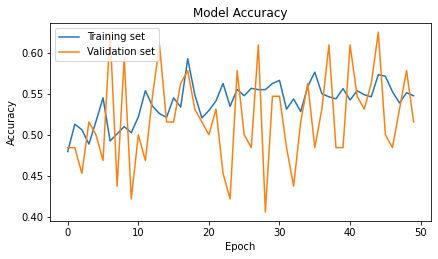

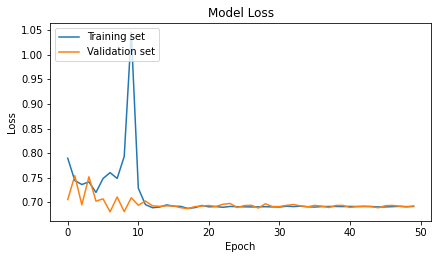

In [30]:
plt.figure( figsize = (15,8)) 
    
plt.subplot(221)  
# Accuracy 
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')
plt.show()


# Loss
plt.figure( figsize = (15,8)) 
plt.subplot(222)  
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')
plt.show()

In [31]:
print("train_accuracy" )
print(history.history['accuracy'])

train_accuracy
[0.4795673191547394, 0.5128534436225891, 0.5062500238418579, 0.48875001072883606, 0.5162500143051147, 0.5450000166893005, 0.4925000071525574, 0.5012500286102295, 0.5099999904632568, 0.5024999976158142, 0.5218508839607239, 0.5537499785423279, 0.5350000262260437, 0.525706946849823, 0.5212500095367432, 0.544987142086029, 0.5337499976158142, 0.5925449728965759, 0.5487499833106995, 0.5205655694007874, 0.5295630097389221, 0.5412499904632568, 0.5625, 0.5347043871879578, 0.5552698969841003, 0.5475578308105469, 0.5565552711486816, 0.5550000071525574, 0.5550000071525574, 0.5625, 0.5662500262260437, 0.53125, 0.5437018275260925, 0.5282776355743408, 0.5587499737739563, 0.5762500166893005, 0.550000011920929, 0.5462499856948853, 0.543749988079071, 0.5562499761581421, 0.5424164533615112, 0.5537499785423279, 0.5487499833106995, 0.5462725162506104, 0.5732647776603699, 0.5712500214576721, 0.5525000095367432, 0.5387499928474426, 0.5512499809265137, 0.5475000143051147]


In [32]:
print("val_accuracy ")
print(history.history['val_accuracy'])

val_accuracy 
[0.484375, 0.484375, 0.453125, 0.515625, 0.5, 0.46875, 0.625, 0.4375, 0.59375, 0.421875, 0.5, 0.46875, 0.546875, 0.609375, 0.515625, 0.515625, 0.5625, 0.578125, 0.53125, 0.515625, 0.5, 0.53125, 0.453125, 0.421875, 0.578125, 0.5, 0.484375, 0.609375, 0.40625, 0.546875, 0.546875, 0.484375, 0.4375, 0.515625, 0.5625, 0.484375, 0.53125, 0.609375, 0.484375, 0.484375, 0.609375, 0.546875, 0.53125, 0.5625, 0.625, 0.5, 0.484375, 0.53125, 0.578125, 0.515625]


In [33]:
print("train_loss")
print(history.history['loss'])


train_loss
[0.78968346118927, 0.744377851486206, 0.7363044619560242, 0.7415766716003418, 0.7202094793319702, 0.748491644859314, 0.760470449924469, 0.7486625909805298, 0.7931650280952454, 1.0459715127944946, 0.7287962436676025, 0.6955682635307312, 0.6891767382621765, 0.6904674768447876, 0.6948645114898682, 0.6922473311424255, 0.691853940486908, 0.6877998113632202, 0.6893150210380554, 0.6936513185501099, 0.6909670233726501, 0.6914337873458862, 0.6900236010551453, 0.6917638182640076, 0.6912345290184021, 0.6909942030906677, 0.6907646656036377, 0.6910154819488525, 0.6911678314208984, 0.6908742785453796, 0.690575361251831, 0.6921546459197998, 0.6915106773376465, 0.6922730803489685, 0.6911506652832031, 0.6905222535133362, 0.6915045976638794, 0.6916394233703613, 0.6917087435722351, 0.6914736032485962, 0.691832423210144, 0.6914419531822205, 0.6916418671607971, 0.6916667819023132, 0.6907503008842468, 0.6907553672790527, 0.6913836002349854, 0.691916286945343, 0.6914243102073669, 0.691642224788665

In [34]:
print("val_loss")
print(history.history['val_loss'])


val_loss
[0.7057557106018066, 0.7541857957839966, 0.6950252056121826, 0.7520244121551514, 0.7024391889572144, 0.7072111964225769, 0.680834174156189, 0.7109755277633667, 0.6812102794647217, 0.7093731760978699, 0.6942005157470703, 0.7028012275695801, 0.6929941177368164, 0.6919670104980469, 0.6928919553756714, 0.692659854888916, 0.6892239451408386, 0.6873024702072144, 0.6913506984710693, 0.6926718950271606, 0.6936800479888916, 0.6916710138320923, 0.6962159276008606, 0.697733461856842, 0.6895986795425415, 0.6934260129928589, 0.6941628456115723, 0.6884943246841431, 0.6971012353897095, 0.6915439963340759, 0.6915411353111267, 0.6939284801483154, 0.69565749168396, 0.6927469968795776, 0.6910607814788818, 0.693865180015564, 0.6921941041946411, 0.6895425319671631, 0.6938085556030273, 0.6937928795814514, 0.6896599531173706, 0.6917264461517334, 0.6922433376312256, 0.6911894679069519, 0.689090371131897, 0.6932917237281799, 0.6938178539276123, 0.6922370195388794, 0.6906536817550659, 0.692762970924377

In [35]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = history.history['lr']

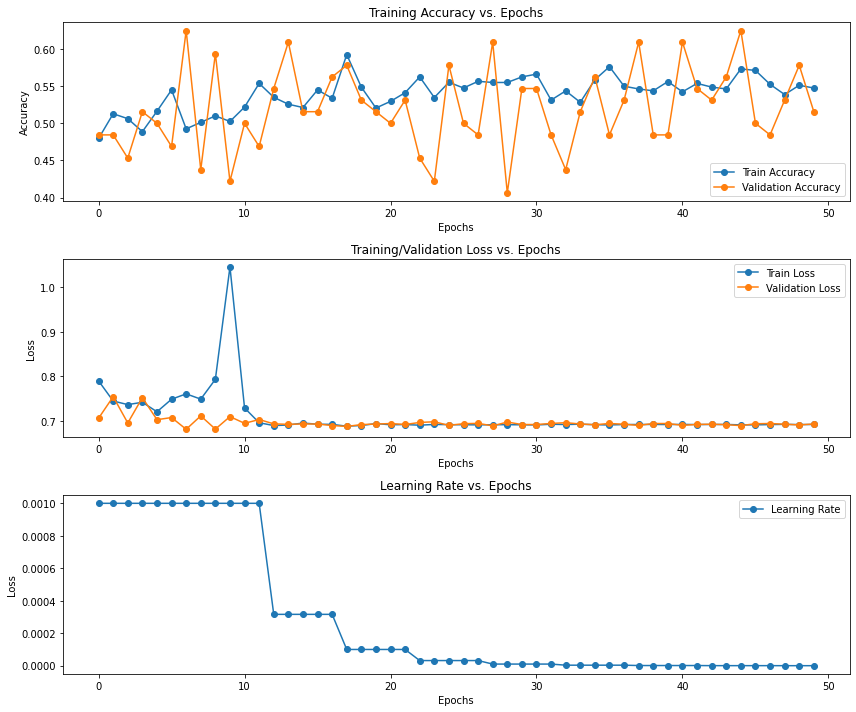

In [36]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

In [37]:
test_dataset = '/content/drive/MyDrive/FakevsReal/FakevsReal/Validation'

In [38]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical')

Found 1116 images belonging to 2 classes.


In [39]:
predictions = model.predict(test_generator)

35/35 [==============================] - 20s 528ms/step


In [41]:
train_loss, train_accuracy, train_precision, train_recall, train_auc, train_F1_Score = model.evaluate(train_generator, batch_size=BATCH_SIZE)

83/83 [==============================] - 73s 871ms/step - loss: 0.6917 - accuracy: 0.5482 - precision: 0.5482 - recall: 0.5482 - auc: 0.5482 - f1_Score: 0.3541


In [43]:
print(f"Train Loss:     {train_loss}")
print(f"Train Accuracy: {train_accuracy}")
print(f"Train Precision: {train_precision}")
print(f"Train Recall: {train_recall}")
print(f"Train AUC: {train_auc}")
print(f"Train F1_Score: {np.mean(train_F1_Score)}")

Train Loss:     0.6916590929031372
Train Accuracy: 0.5482156276702881
Train Precision: 0.5482156276702881
Train Recall: 0.5482156276702881
Train AUC: 0.5482156276702881
Train F1_Score: 0.35409513115882874


In [40]:
test_loss, test_accuracy, test_precision, test_recall, test_auc, test_F1_Score = model.evaluate(test_generator, batch_size=BATCH_SIZE)

35/35 [==============================] - 15s 429ms/step - loss: 0.6924 - accuracy: 0.5251 - precision: 0.5251 - recall: 0.5251 - auc: 0.5251 - f1_Score: 0.3443


In [42]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test AUC: {test_auc}")
print(f"Test F1_Score: {np.mean(test_F1_Score)}")

Test Loss:     0.692441999912262
Test Accuracy: 0.5250896215438843
Test Precision: 0.5250896215438843
Test Recall: 0.5250896215438843
Test AUC: 0.5250896215438843
Test F1_Score: 0.3443008363246918


In [48]:
A=history.history['accuracy']
A_v=history.history['val_accuracy']
L=history.history['loss']
L_v=history.history['val_loss']
Auc=history.history['auc']
Auc_v=history.history['val_auc']
P=history.history['precision']
P_v=history.history['val_precision']
F1=history.history['f1_Score']
F1_v=history.history['val_f1_Score']
import pandas as pd
data_to_submit = pd.DataFrame({
    'accuracy':A,
    'val_accuracy':A_v,
    'loss': L,
    'val_loss': L_v,
    'auc':Auc,
    'val_auc':Auc_v,
    'precision':P,
    'val_precision':P_v,
    'f1_score':F1,
    'val_f1_score':F1_v
})
data_to_submit.to_csv('ConvNext_Tiny.csv', index = False)